In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP, OjaRNN
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
import configs

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Plot Ms for different walk biases

3.07020800077861
2.5187042053626163
1.890662123008503


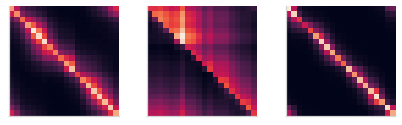

In [10]:
lrs_ps = [
    [1, 1, 1],
    [1, 5, 1],
    [1, 1, 5]
]

fig, axs = plt.subplots(1,3, figsize=(6,2))
for idx, lrs_p in enumerate(lrs_ps):
    num_steps = 1000
    num_states = 20

    dset = inputs.Sim1DWalk(
        num_steps=num_steps, left_right_stay_prob=lrs_p,
        num_states=num_states
        )

    # Set up network
    save_path = '../trained_models/baseline/'
    model_path = save_path + 'model.pt'
    net_configs_path = save_path + 'net_configs.p'
    with open(net_configs_path, 'rb') as f:
        net_configs = pickle.load(f)
    net_configs.pop('num_states')
    net = STDP_SR(num_states=num_states, **net_configs)
    net.load_state_dict(torch.load(model_path))
    
    # Set up dataset
    dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
    dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
    input_states = []
    for t in range(dg_inputs.shape[0]):
        input_states.append(np.argwhere(dg_inputs[t,0])[0,0])
    input_states = np.array(input_states)
    
    for step in range(dset.num_steps):
        curr_dg_input = dg_inputs[step].unsqueeze(0)
        curr_dg_mode = dg_modes[step].unsqueeze(0)
        reset = True if step == 0 else False
        _, outputs = net(curr_dg_input, curr_dg_mode, reset=reset)
    
    print(np.sum(np.abs(net.get_T().detach().numpy() - dset.est_T)))
    ax = axs[idx]
    ax.imshow(net.get_M(0.9).detach().numpy().squeeze())
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.savefig('1dbias_Ms.png', dpi=200)
plt.show()

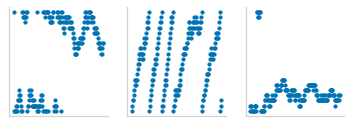

In [11]:
lrs_ps = [
    [1, 1, 1],
    [1, 5, 1],
    [1, 1, 5]
]

fig, axs = plt.subplots(1,3, figsize=(6,2))
for idx, lrs_p in enumerate(lrs_ps):
    num_steps = 200
    num_states = 20

    dset = inputs.Sim1DWalk(
        num_steps=num_steps, left_right_stay_prob=lrs_p,
        num_states=num_states
        )
    
    ax = axs[idx]
    ax.scatter(np.arange(dset.ys.size), dset.ys, s=10)
    ax.set_xticks([]); ax.set_yticks([])